<a href="https://colab.research.google.com/github/hesnacaliskan/Cure_the_Princess/blob/main/curetheprincess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
import torch
import torch.nn as nn
#import torchvision
#import torchvision.transforms as transforms
import torch.optim as optim

In [48]:
torch.manual_seed(190401007)

In [86]:
train_url = 'https://raw.githubusercontent.com/hesnacaliskan/Cure_the_Princess/main/cure_the_princess_train.csv?token=GHSAT0AAAAAACAT6TIGSXLHFA6KRIAV6AW4ZBROO2A'
val_url  = 'https://raw.githubusercontent.com/hesnacaliskan/Cure_the_Princess/main/cure_the_princess_validation.csv?token=GHSAT0AAAAAACAT6TIGMJVT442WXQWOZ5GGZBROPAQ'
test_url = 'https://raw.githubusercontent.com/hesnacaliskan/Cure_the_Princess/main/cure_the_princess_test.csv?token=GHSAT0AAAAAACAT6TIHH3SRY4WC4VI35XFUZBROORQ'

In [87]:
train_data = pd.read_csv(train_url)
train_labels = train_data.iloc[:, -1]
train_data = train_data.iloc[:, :-1]

val_data = pd.read_csv(val_url)
val_labels = val_data.iloc[:, -1]
val_data = val_data.iloc[:, :-1] 

test_data = pd.read_csv(test_url)
test_labels = test_data.iloc[:, -1]
test_data = test_data.iloc[:, :-1]


In [88]:
train_data = torch.Tensor(train_data.values)
train_labels = torch.Tensor(train_labels.values).view(-1, 1)

test_data = torch.Tensor(test_data.values)
test_labels = torch.Tensor(test_labels.values).view(-1, 1)

val_data = torch.Tensor(val_data.values)
val_labels = torch.Tensor(val_labels.values).view(-1, 1)


In [89]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out


In [90]:
input_size = 13
hidden_size1 = 100
hidden_size2 = 50
output_size = 1
learning_rate = 0.001
epochs = 100
batch_size = 32

model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [91]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Train
    model.train()
    train_loss = 0.0
    for i in range(0, len(train_data), batch_size):
        # Get batch of data
        batch_data = train_data[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels.view(-1, 1))
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_data.size(0)
    train_loss = train_loss / len(train_data)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(val_data), batch_size):
            # Get batch of data
            batch_data = val_data[i:i+batch_size]
            batch_labels = val_labels[i:i+batch_size]            

            # Forward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels.view(-1, 1))
            val_loss += loss.item() * batch_data.size(0)
        val_loss = val_loss / len(val_data)
        val_losses.append(val_loss)
    
    # Print epoch and loss
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [10/100], Train Loss: 0.4628, Validation Loss: 0.4267
Epoch [20/100], Train Loss: 0.3625, Validation Loss: 0.3201
Epoch [30/100], Train Loss: 0.3099, Validation Loss: 0.2658
Epoch [40/100], Train Loss: 0.2803, Validation Loss: 0.2379
Epoch [50/100], Train Loss: 0.2600, Validation Loss: 0.2208
Epoch [60/100], Train Loss: 0.2434, Validation Loss: 0.2083
Epoch [70/100], Train Loss: 0.2295, Validation Loss: 0.1993
Epoch [80/100], Train Loss: 0.2176, Validation Loss: 0.1918
Epoch [90/100], Train Loss: 0.2073, Validation Loss: 0.1855
Epoch [100/100], Train Loss: 0.1980, Validation Loss: 0.1803


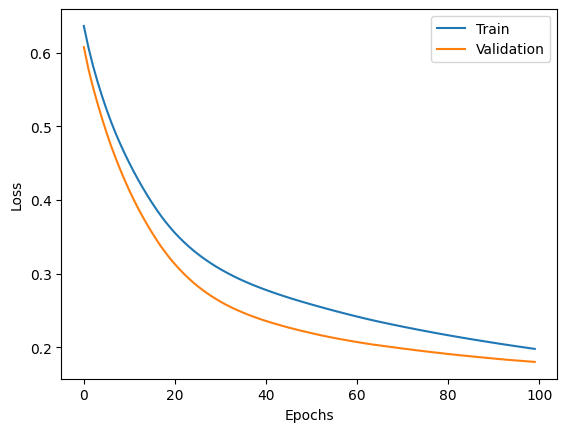

In [92]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [99]:
best_model_params = None
best_val_loss = float('inf')
patience = 20
counter = 0

for epoch in range(epochs):
    # Train
    model.train()
    train_loss = 0.0
    for i in range(0, len(train_data), batch_size):
        # Get batch of data
        batch_data = train_data[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels.view(-1, 1))
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_data.size(0)
    train_loss = train_loss / len(train_data)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(val_data), batch_size):
            # Get batch of data
            batch_data = val_data[i:i+batch_size]
            batch_labels = val_labels[i:i+batch_size]            

            # Forward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels.view(-1, 1))
            val_loss += loss.item() * batch_data.size(0)
        val_loss = val_loss / len(val_data)
        val_losses.append(val_loss)
        
        # Check if validation loss is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_params = model
            counter = 0
        else:
            counter += 1
            
        # Early stopping condition
        if counter >= patience:
            #print(f'Early stopping at epoch {epoch+1}')
            print("Validation loss hasn't improved for {} epochs. Stopping training early.".format(patience))
            break
    
    # Print epoch and loss
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch [10/100], Train Loss: 0.0883, Validation Loss: 0.1471
Epoch [20/100], Train Loss: 0.0866, Validation Loss: 0.1475
Validation loss hasn't improved for 20 epochs. Stopping training early.


In [94]:
    # Compute validation accuracy, precision, recall and F1 score
    tp = 0  # True positives
    fp = 0  # False positives
    tn = 0  # True negatives
    fn = 0  # False negatives
    best_model_params.eval()
    with torch.no_grad():
        for i in range(0, len(test_data), batch_size):
            # Get batch of data
            batch_data = test_data[i:i+batch_size]
            batch_labels = test_labels[i:i+batch_size]

            # Forward pass
            outputs = best_model_params(batch_data)
            predicted_labels = (outputs >= 0.5).float()

            # Update confusion matrix
            tp += torch.sum(predicted_labels * batch_labels).item()
            fp += torch.sum(predicted_labels * (1 - batch_labels)).item()
            tn += torch.sum((1 - predicted_labels) * (1 - batch_labels)).item()
            fn += torch.sum((1 - predicted_labels) * batch_labels).item()

            # Compute validation loss
            loss = criterion(outputs, batch_labels.view(-1, 1))
            val_loss += loss.item() * batch_data.size(0)
        val_loss = val_loss / len(test_data)

    # Compute accuracy, precision, recall and F1 score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    print(f'Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}')


Test Accuracy: 0.9326, Test Precision: 0.9590, Test Recall: 0.9046, Test F1: 0.9310
